In [1]:
!CUDA_VISIBLE_DEVICE=2

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
import celltypist

In [7]:
def load_VAE():
    autoencoder = VAE(
        num_genes=19423,
        device='cuda',
        seed=0,
        hparams="",
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/WOT_D0-8_no_D0.5&D1/model_seed=0_step=999999.pt')) #replace by your own AE
    return autoencoder

In [4]:
# load WOT dataset
ori_adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/WOT/filted_data.h5ad')
ori_adata = ori_adata[np.where(np.in1d(ori_adata.obs['period'], ['D0','D0.5','D1','D1.5','D2','D2.5','D3','D3.5','D4','D4.5','D5','D5.5','D6','D6.5','D7','D7.5','D8']))[0]]#[::15]
tmp_ = sc.read_10x_h5('../data/WOT/GSM3195672_D6_Dox_C1_gene_bc_mat.h5')
ori_adata.var_names_make_unique()
gene_names = tmp_.var_names[ori_adata.var_names.astype(np.int32)]
sc.pp.normalize_total(ori_adata, target_sum=1e4)
ori_celltype = ori_adata.obs['period']

In [17]:
adata = ori_adata.copy()
adata.var_names = gene_names

adata = adata[np.where(np.in1d(adata.obs['period'], ['D0','D0.5','D1','D1.5']))[0]][::8]

gene_names = adata.var_names
adata.var_names_make_unique()
celltype = adata.obs['period']#[::5]
cell_data = adata.X#[::5]

cell_data.shape

(1713, 19423)

In [16]:
# load generated cells with different Gradient Interpolations
stage_list = [str(i) for i in np.array(range(1,20))/2]
cell_gen = []
cell_stage = []
cell_dis = []
for i in stage_list:
    npzfile=np.load(f'../data/new_version/continue_state/state4v_{i}.npz',allow_pickle=True)

    cell_gen_all = npzfile['cell_gen'][::27]

    autoencoder = load_VAE()
    cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).detach().cpu().numpy()

    ori = ad.AnnData(cell_gen_all, dtype=np.float32)

    cell_gen.append(ori.X)
    cell_stage+=[str(10-float(i))]*ori.X.shape[0]
    cell_dis+=[10-float(i)]*ori.X.shape[0]

cell_gen = np.concatenate(cell_gen)
cell_gen.shape

(2128, 19423)

draw plot

In [18]:
real_adata = ad.AnnData(cell_data, dtype=np.float32)
gen_adata = ad.AnnData(cell_gen, dtype=np.float32)
real_adata.obs['celltype'] = celltype[:cell_data.shape[0]]
real_adata.var_names = gene_names
gen_adata.var_names = gene_names

sc.pp.log1p(real_adata)
sc.pp.highly_variable_genes(real_adata)
gen_adata = gen_adata[:,real_adata.var['highly_variable']]
real_adata = real_adata[:, real_adata.var.highly_variable]
sc.pp.scale(real_adata)

sc.pp.log1p(gen_adata)
sc.pp.scale(gen_adata)

sc.tl.pca(real_adata, svd_solver='arpack')

X_pca = np.dot(gen_adata.X, real_adata.varm['PCs'])
gen_adata.obsm['X_pca'] = X_pca

adata = sc.concat((real_adata,gen_adata))

adata.obs['cell_name'] = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]
celltypes = np.concatenate((celltype, cell_stage))
adata.obs['celltype'] = pd.Categorical(celltypes)
celldis = np.concatenate(([np.nan]*cell_data.shape[0], cell_stage)).astype(np.float32)
adata.obs['celldis'] = celldis
adata

AnnData object with n_obs × n_vars = 3841 × 1914
    obs: 'cell_name', 'celltype', 'celldis'
    obsm: 'X_pca'

In [19]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

... storing 'cell_name' as categorical


<AxesSubplot:title={'center':'celldis'}, xlabel='UMAP1', ylabel='UMAP2'>

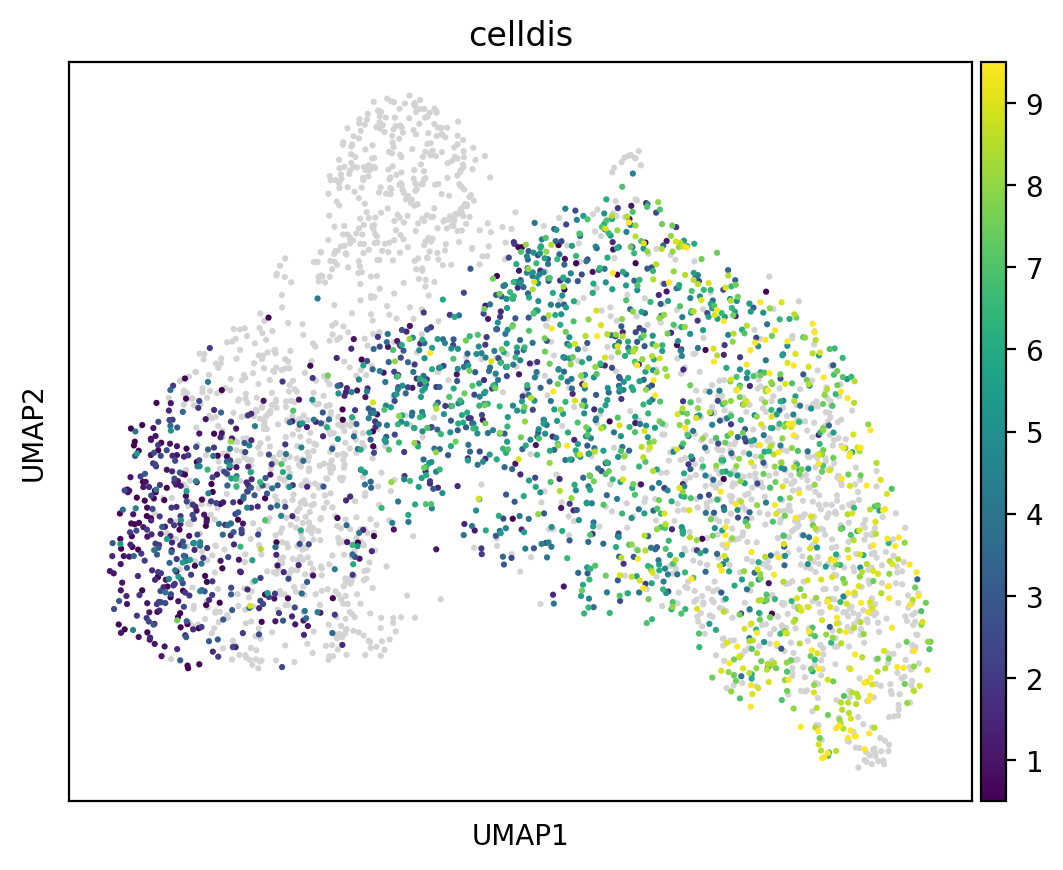

In [20]:
n_cell_types = len(np.unique(adata.obs['celltype']))  
cmap = plt.get_cmap('viridis', n_cell_types)  # Replace 'viridis' with your desired colormap  
colors = [cmap(i) for i in range(cmap.N)]
cell_type_color_map = dict(zip(np.unique(adata.obs['celltype']), colors))
cell_type_color_map['D0']='tab:red'
cell_type_color_map['D0.5']='tab:orange'
cell_type_color_map['D1']='tab:blue'
cell_type_color_map['D1.5']='tab:green'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata=adata,color="celldis", groups=list(np.unique(adata.obs['celldis'])), size=20, show=False)

<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

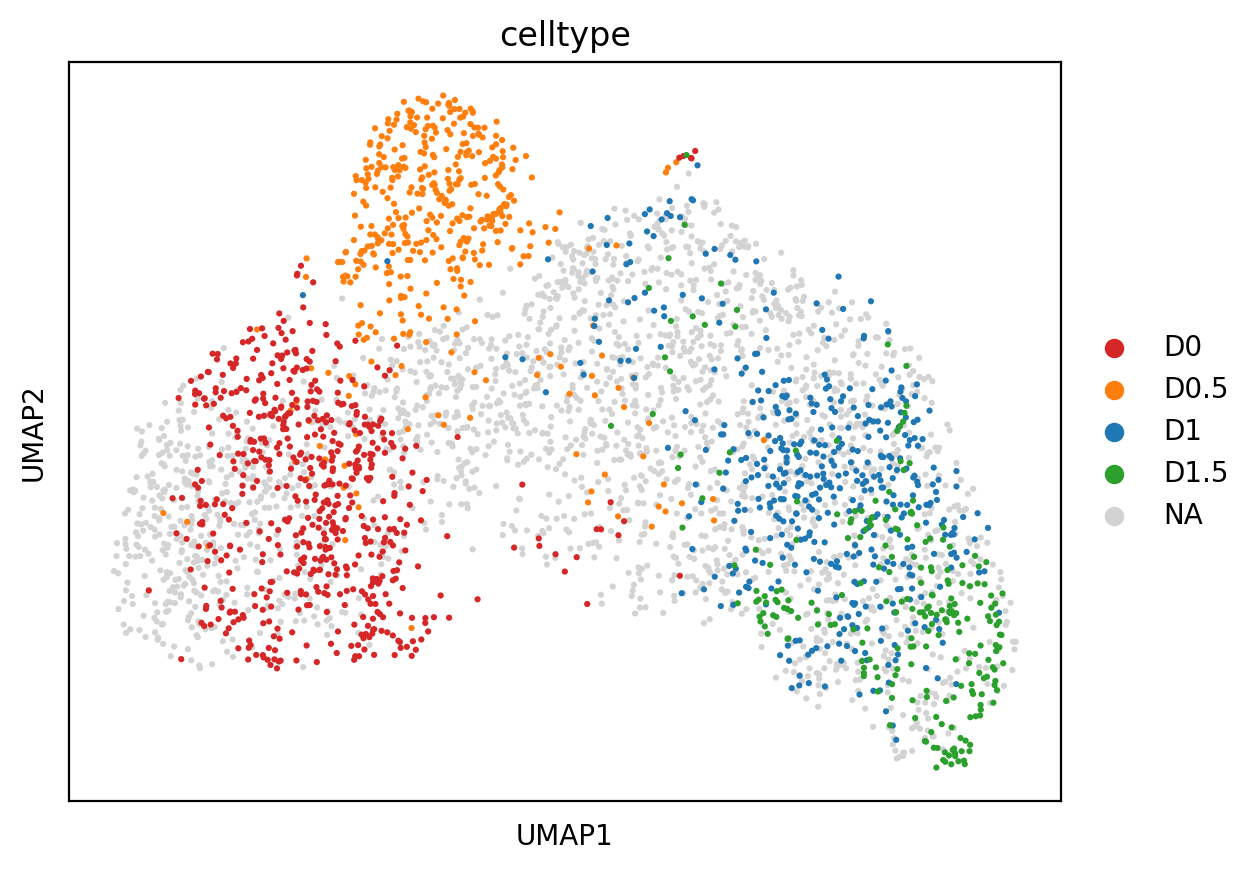

In [21]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata=adata,color="celltype", groups = ['D0','D0.5','D1','D1.5'],size=20,palette=cell_type_color_map, show=False)

In [22]:
sc.tl.paga(adata, groups='celltype')
adata.uns['iroot'] = np.flatnonzero(adata.obs['celltype']  == 'D0')[0]
sc.tl.dpt(adata)

psudotime

In [23]:
dis_gen = []
for day in np.unique(adata.obs['celltype'].values):
    dis_mean = adata[adata.obs['celltype']==day].obs['dpt_pseudotime'].mean()
    print(day,dis_mean)
    dis_gen.append(dis_mean)

0.5 0.2485089
1.0 0.26157996
1.5 0.31326538
2.0 0.3137361
2.5 0.3501102
3.0 0.41813824
3.5 0.4460446
4.0 0.47048154
4.5 0.4827039
5.0 0.5411645
5.5 0.5302825
6.0 0.5474609
6.5 0.59526455
7.0 0.63357073
7.5 0.6900622
8.0 0.6843446
8.5 0.74405044
9.0 0.7369705
9.5 0.7782321
D0 0.16772321
D0.5 0.44924793
D1 0.751495
D1.5 0.8261553


Text(0, 0.5, 'pseudotime')

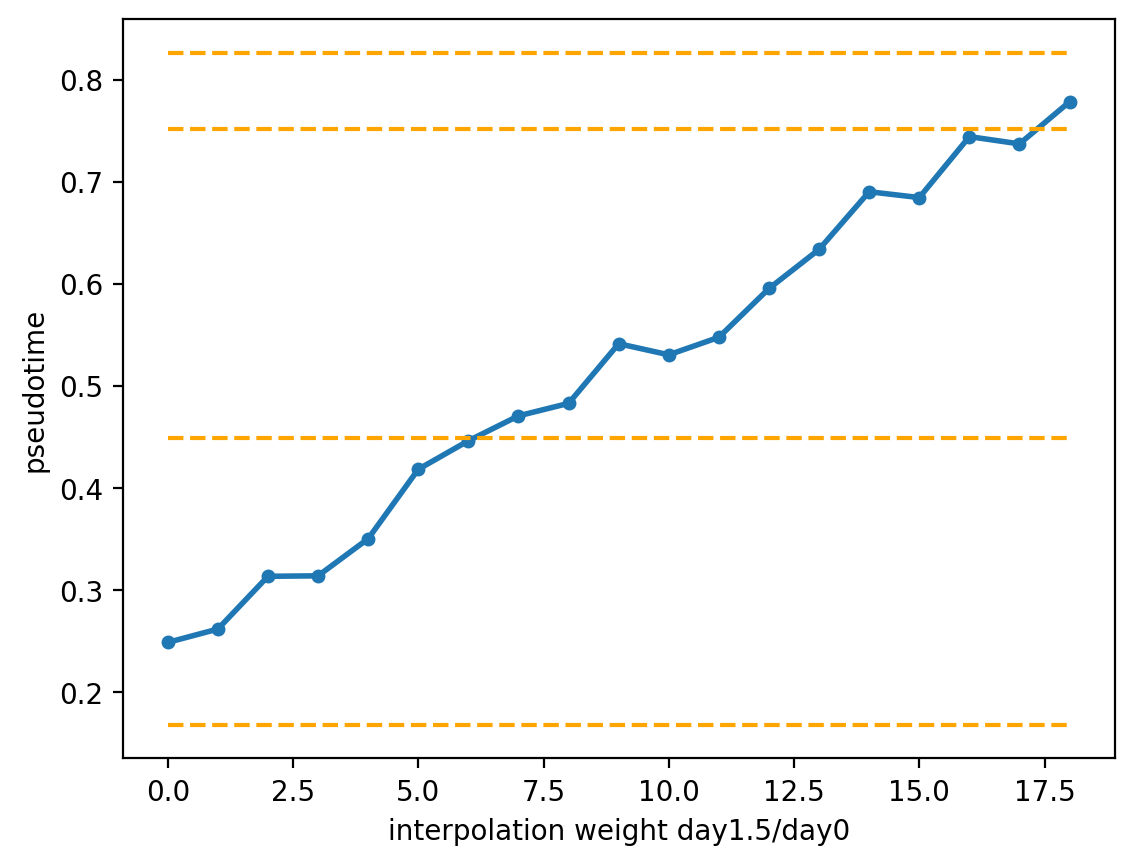

In [24]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots()
x = list(range(len(dis_gen[:-4])))
ax.plot(x, dis_gen[:-4], linewidth=2, marker='o', markersize=4)

y_values = dis_gen[-4:]
ax.hlines(y_values[0], xmin=min(x), xmax=max(x), colors='orange', linestyles='--', label=f'day 0')
ax.hlines(y_values[1], xmin=min(x), xmax=max(x), colors='orange', linestyles='--', label=f'day 0.5')
ax.hlines(y_values[2], xmin=min(x), xmax=max(x), colors='orange', linestyles='--', label=f'day 1')
ax.hlines(y_values[3], xmin=min(x), xmax=max(x), colors='orange', linestyles='--', label=f'day 1.5')

ax.set_xlabel('interpolation weight day1.5/day0')  
ax.set_ylabel('pseudotime')